In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pymc3 as pm
import numpy as np
import theano.tensor as tt
import theano
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from pymc3.backends import HDF5, text

%autoreload 2



WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5110, 6021))


In [2]:
theano.__version__

'0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291'

# Introduction

I'd like to try doing multiclass classification with a deep neural network. The network architecture is a feed-forward network with one hidden layer in between the input and output; `n_hidden` units is a hyperparameter.

# Model Specification

Because neural networks are the highlight here, I will first do the model specification up-front.

In [3]:
def make_nn(ann_input, ann_output, n_hidden):
    """
    Makes a feed forward neural network with n_hidden layers for doing multi-
    class classification.
    
    Feed-forward networks are easy to define, so I have not relied on any 
    other Deep Learning frameworks to define the neural network here.
    """
    init_1 = np.random.randn(ann_input.shape[1], n_hidden)
    init_2 = np.random.randn(n_hidden, n_hidden)
    init_out = np.random.randn(n_hidden, ann_output.shape[1])
    
    with pm.Model() as nn_model:
        # Define weights
        weights_1 = pm.Normal('w_1', mu=0, sd=1, 
                              shape=(ann_input.shape[1], n_hidden),
                              testval=init_1)
        weights_2 = pm.Normal('w_2', mu=0, sd=1,
                              shape=(n_hidden, n_hidden),
                              testval=init_2)
        weights_out = pm.Normal('w_out', mu=0, sd=1, 
                                shape=(n_hidden, ann_output.shape[1]),
                                testval=init_out)

        # Define activations
        acts_1 = pm.Deterministic('activations_1', 
                                  tt.tanh(tt.dot(ann_input, weights_1)))
        acts_2 = pm.Deterministic('activations_2', 
                                  tt.tanh(tt.dot(acts_1, weights_2)))
        acts_out = pm.Deterministic('activations_out', 
                                    tt.nnet.softmax(tt.dot(acts_2, weights_out)))  # noqa
        
        # Define likelihood
        out = pm.Multinomial('likelihood', n=1, p=acts_out, 
                             observed=ann_output)
        
    return nn_model

# Preprocess Data

## Basic Cleaning

Now, let's read in the dataset. There's a bunch of preprocessing that has to happen. I happened to have this code written for the IACS 2017 data science bootcamp, and copied it over from there. It's commented out because it takes some time to execute, and if executed once, it needn't be executed again.

In [4]:
# df = pd.read_csv('datasets/covtype.data', header=None)

# columns = [
#     'Elevation',
#     'Aspect',
#     'Slope',
#     'Horizontal_Distance_To_Hydrology',
#     'Vertical_Distance_To_Hydrology',
#     'Horizontal_Distance_To_Roadways',
#     'Hillshade_9am',
#     'Hillshade_Noon',
#     'Hillshade_3pm',
#     'Horizontal_Distance_To_Fire_Points'
# ]

# # Add in wilderness area data (binary)
# for i in range(1, 5):
#     columns.append('Wilderness_Area_{0}'.format(i))
    
# # Add in soil type data (binary)
# for i in range(1, 41):
#     columns.append('Soil_Type_{0}'.format(i))

# # Add in soil cover type
# columns.append('Cover_Type')

# df.columns = columns

# # Add in soil codes. These were downloaded from the UCI repository.
# soil_codes = pd.read_csv('datasets/climatic_geologic_zone.csv')
# soil_dict = soil_codes.set_index('soil_type').to_dict()

# # Add geologic and climatic zone code to soil type
# for i in range(1, 41):
#     df.loc[df['Soil_Type_{i}'.format(i=i)] == 1, 'Climatic_Zone'] = soil_dict['climatic_zone'][i]
#     df.loc[df['Soil_Type_{i}'.format(i=i)] == 1, 'Geologic_Zone'] = soil_dict['geologic_zone'][i]
    
# # Encode one-of-K for the geologic zone, climatic zone, and cover_type encodings.
# # This is important because the geologic and climatic zones aren't ordinal - they are strictly categorical.
# enc = OneHotEncoder()
# clm_zone_enc = enc.fit_transform(df['Climatic_Zone'].values.reshape(-1, 1)).toarray()
# geo_zone_enc = enc.fit_transform(df['Geologic_Zone'].values.reshape(-1, 1)).toarray()
# cov_type_enc = enc.fit_transform(df['Cover_Type'].values.reshape(-1, 1)).toarray()

# for i in range(clm_zone_enc.shape[1]):
#     df['Climatic_Zone_{i}'.format(i=i)] = clm_zone_enc[:, i]

# for i in range(geo_zone_enc.shape[1]):
#     df['Geologic_Zone_{i}'.format(i=i)] = geo_zone_enc[:, i]
    
# del df['Climatic_Zone']
# del df['Geologic_Zone']

# df.to_csv('datasets/covtype_preprocess.csv')


In [5]:
df = pd.read_csv('../datasets/covtype_preprocess.csv', index_col=0)
df.shape

(581012, 66)

Let's now make the X and Y matrices. We use patsy to give us a quick and fast way to turn categorical variables into one-of-K columns.

In [6]:
df['Cover_Type'] = df['Cover_Type'].apply(lambda x: str(x))

In [7]:
output_col = 'Cover_Type'
input_cols = [c for c in df.columns if c != output_col]
input_formula = ''.join(c + ' + ' for c in input_cols)
input_formula = input_formula + '-1'

import patsy
from sklearn.preprocessing import scale, normalize
X = patsy.dmatrix(formula_like=input_formula, 
                  data=df, 
                  return_type='dataframe')
# X = normalize(X)

Y = patsy.dmatrix(formula_like='Cover_Type -1',
                  data=df,
                  return_type='dataframe')
print(X.shape, Y.shape)

(581012, 66) (581012, 7)


In [8]:
Y.head()

,Cover_Type[1],Cover_Type[2],Cover_Type[3],Cover_Type[4],Cover_Type[5],Cover_Type[6],Cover_Type[7]
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Balance Classes

We will balance out the classes to make them evenly distributed.

In [9]:
from sklearn.preprocessing import MinMaxScaler

downsampled_targets = []

for i in range(1, 7+1):
    # print(f'target[{i}]')
    target = Y[Y['Cover_Type[{i}]'.format(i=i)] == 1]
    # print(len(target))
    downsampled_targets.append(target.sample(2747))
    
mms = MinMaxScaler()
X_tfm = pm.floatX(mms.fit_transform(X[input_cols]))

Y_downsampled = pd.concat(downsampled_targets)
Y_downsamp = pm.floatX(Y_downsampled)

X_downsampled = X_tfm[Y_downsampled.index]
X_downsamp = pm.floatX(X_downsampled)


In [37]:
X_downsamp.shape

(19229, 65)

In [39]:
from models.feedforward import ForestCoverModel
fcm = ForestCoverModel(n_hidden=20,)
fcm.fit(X_downsamp, Y_downsamp)

AttributeError: 'ForestCoverModel' object has no attribute 'num_out'

In [13]:
X_downsampled.shape

(19229, 65)

In [14]:
X_downsamp.dtype

dtype('float32')

In [15]:
n_hidden = 20  # define the number of hidden units

# Model Execution

We now make the model with {{n_hidden}} hidden units.

In [15]:
model = make_nn(X_downsamp, Y_downsamp, n_hidden=n_hidden)

/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


In [17]:
with model:
    # s = theano.shared(pm.floatX(1.1))
    # inference = pm.ADVI(cost_part_grad_scale=s)
    approx = pm.fit(500000, 
                    callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-1)])

Average Loss = 12,823: 100%|██████████| 500000/500000 [47:53<00:00, 174.00it/s]  
Finished [100%]: Average Loss = 12,823


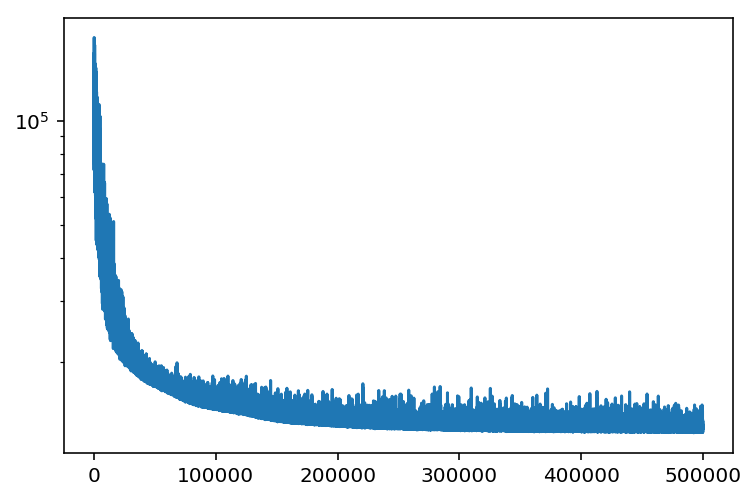

In [24]:
plt.plot(approx.hist)
plt.yscale('log')

In [25]:
with model:
    trace = approx.sample(1000)

In [26]:
# pm.traceplot(trace, varnames=['w_1'])

In [27]:
# pm.traceplot(trace, varnames=['w_2'])

In [28]:
# pm.traceplot(trace, varnames=['w_out'])

In [29]:
with model:
    samp_ppc = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:31<00:00, 31.33it/s]


# Results

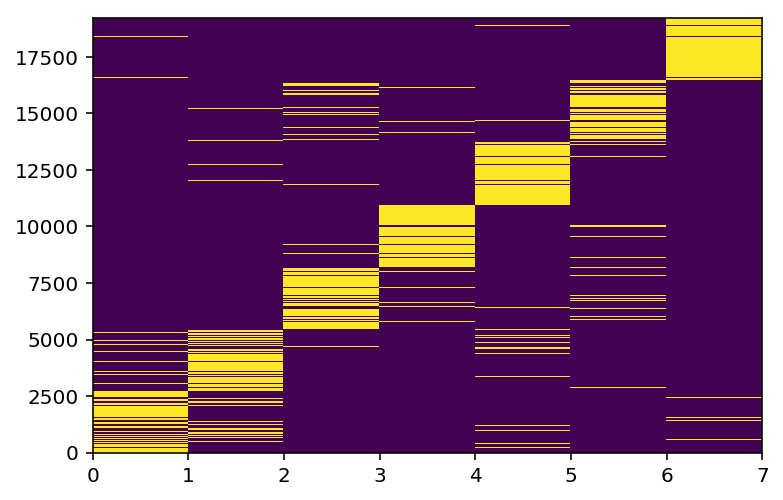

In [30]:
preds_proba = samp_ppc['likelihood'].mean(axis=0)
preds = (preds_proba == np.max(preds_proba, axis=1, keepdims=True)) * 1
plt.pcolor(preds)
plt.savefig('figures/class_predictions.png', dpi=600)

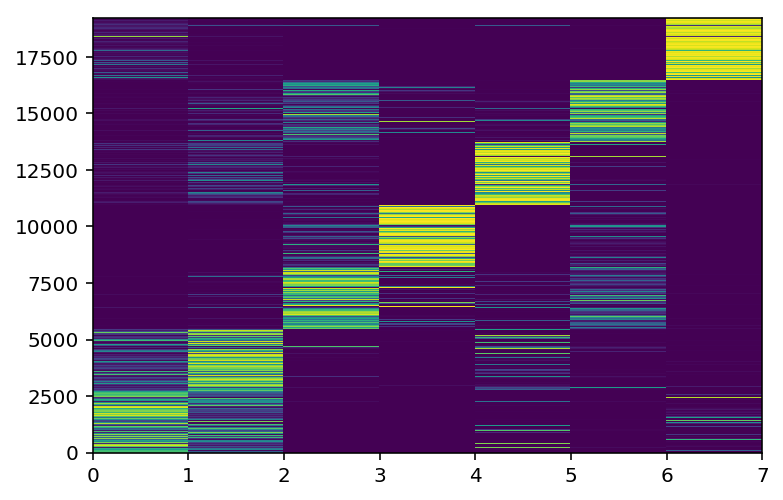

In [31]:
plt.pcolor(preds_proba)
plt.savefig('figures/class_probabilities.png', dpi=600)

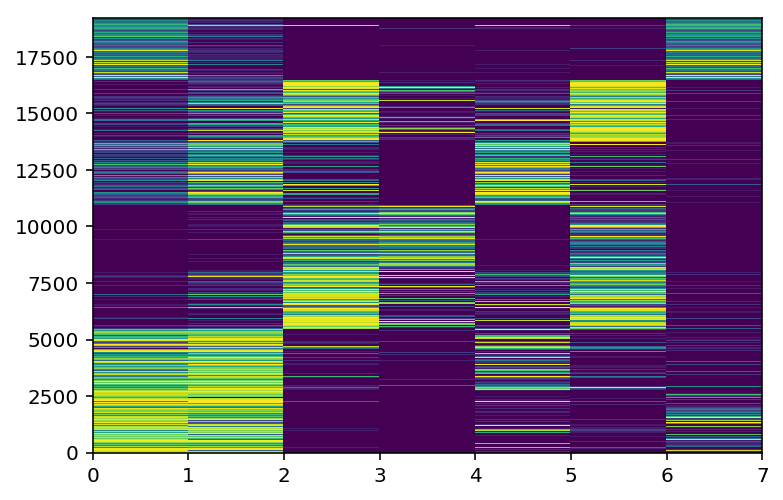

In [32]:
plt.pcolor(samp_ppc['likelihood'].std(axis=0))
plt.savefig('figures/class_uncertainties.png', dpi=600)

In [33]:
from sklearn.metrics import classification_report

print(classification_report(Y_downsamp, preds))

             precision    recall  f1-score   support

          0       0.75      0.71      0.73      2747
          1       0.74      0.61      0.67      2747
          2       0.72      0.75      0.74      2747
          3       0.91      0.97      0.94      2747
          4       0.83      0.93      0.88      2747
          5       0.76      0.73      0.74      2747
          6       0.91      0.95      0.93      2747

avg / total       0.80      0.81      0.80     19229



Compared to the logistic regression notebook, we have higher performance!

# Fit `sklearn`-like estimator